# **1)Analysis Using LSTM Model**

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras import optimizers
from keras.models import load_model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
%matplotlib inline 
import os

**Some function definitions which will generate input and output pair of sequences.**

In [ ]:
def create_sequences(data, length, output):
    nsignals = data.shape[1]
    siglen = data.shape[0]
    sampX=[]
    sampy=[]
    indx = siglen - output - length
    for j in range(nsignals):
        sig = data[:,j]
        for i in range(indx):
            tempX = sig[i:length+i]
            tempy = sig[i+length:length+i+output]
            sampX.append(tempX)
            sampy.append(tempy)
    nsamples = len(sampX)        
    X = np.array(sampX).reshape(nsamples, length, 1)
    y = np.array(sampy).reshape(nsamples, output) 
    return X, y  



**Function for splitting training and testing dataset:**

In [ ]:
def define_test_dataset(X, y, n_patterns, ntestsigs):
    testindex = int(np.floor(ntestsigs*n_patterns))
    X_train = X[:-testindex,:,:]
    y_train = y[:-testindex,:]
    X_test = X[-testindex:,:,:]
    y_test = y[-testindex:,:]
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    return X_train, y_train, X_test, y_test


**Mean absolute scaled error(MASE)**

In [ ]:
def MASE(realData, predictedData):
    """ Regression Error metric = mean absolute scaled error (MASE)"""
    a1 = realData[:,1:]
    a2 = realData[:,:-1]
    maseErr = mean_absolute_error(a1,predictedData[:,1:])/mean_absolute_error(a1,a2)
    return maseErr

# **Now Load datasets**


In [ ]:
ndataset = 5
length = 10
output = 10

**POD mode 1**

In [ ]:

############# POD mode 1
fM1 = h5py.File('PODm1_isotropicTurb32BoxALL.mat')
dataM1 = fM1.get('data')
dataM1 = np.transpose(dataM1)


# configure problem
nsignals = dataM1.shape[1]
siglen = dataM1.shape[0]

# Extract sequences
inputdata = dataM1[:,0:ndataset]
XM1, yM1 = create_sequences(inputdata, length, output)
#np.random.shuffle(X)
#np.random.shuffle(y)
ntestpatterns = siglen - length - output
ntestsigs = 1
X_trainM1, y_trainM1, X_testM1, y_testM1 = define_test_dataset(XM1, yM1, ntestpatterns, ntestsigs)
X_trainM1.shape


(20012, 10, 1)

# Load LSTM Models:

In [ ]:
modelM1 = load_model('isoturb32boxROM_PODm1_c1.1.h5')
print('Loaded PODm1 model')

Loaded PODm1 model


# ROM prediction time index for all POD modes
 **EVALUATE: Predict future instance of POD coeffs and compare with truth value on test signal**



**timeIndex : np.random.randint(0, ntestpatterns + 1)**

In [ ]:
timeIndex = 4252
print('Time Index is', timeIndex)

############# POD mode 1
datainputM1 = X_testM1[timeIndex ,:,:]
datainputM1 = datainputM1.reshape(1, length, 1)
realdataM1 = y_testM1[timeIndex ,:]
realdataM1 = np.transpose(realdataM1).reshape(1,output)
predictedM1 = modelM1.predict(datainputM1, verbose=0)


Time Index is 4252


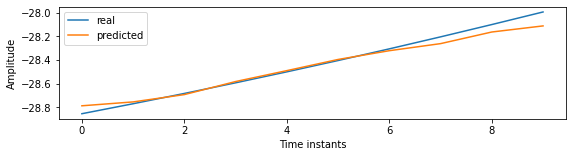

In [ ]:
plt.figure(figsize=(20,7))
plt.figure(1)
plt.subplot(321)
plt.plot(np.transpose(realdataM1), label='real')
plt.plot(np.transpose(predictedM1), label='predicted')
plt.legend
plt.xlabel('Time instants')
plt.ylabel('Amplitude')
plt.legend(['real', 'predicted'], loc='upper left')
plt.show()

**Plot error for all predictions in a model**

In [ ]:

############# POD mode 1
errTotM1 = []
for idx in range(ntestpatterns):
    datainputM1 = X_testM1[idx ,:,:]
    datainputM1 = datainputM1.reshape(1, length, 1)
    realdataM1 = y_testM1[idx ,:]
    realdataM1 = np.transpose(realdataM1).reshape(1,output)
    predictedM1 = modelM1.predict(datainputM1, verbose=0)
    err = MASE(realdataM1, predictedM1)
    errTotM1.append(err)

# Plot MASE 

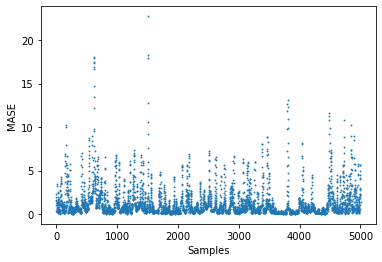

Mean MASE is 1.2742033689763739
STD of MASE is 1.7542231359845724


In [ ]:
xaxis = np.linspace(1,ntestpatterns, ntestpatterns)
plt.scatter(xaxis, errTotM1, s=0.75)
plt.xlabel('Samples')
plt.ylabel('MASE')
plt.show()
print('Mean MASE is', np.mean(errTotM1))
print('STD of MASE is', np.std(errTotM1))

# Plot loss vs epochs:

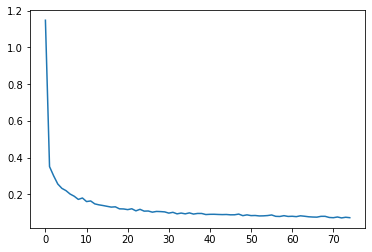

final loss PODm1 0.072893534814736


In [ ]:
ll = np.load('isoturb32boxROM_PODm1_c1.1_res.npz')
plt.plot(ll['loss_history'])
plt.show()
print('final loss PODm1', ll['loss_history'][-1])

# **Analysis using BiLSTM model**

**Functions definitions:**


**Generate input and output pairs of sequences.**

In [ ]:
def create_sequences_BiLSTM(data, length, output):
    nsignals = data.shape[1]
    siglen = data.shape[0]
    sampX=[]
    sampy=[]
    indx = siglen - output - length
    for j in range(nsignals):
        sig = data[:,j]
        for i in range(indx):
            tempX = sig[i:length+i]
            tempy = sig[i+length:length+i+output]
            sampX.append(tempX)
            sampy.append(tempy)
    nsamples = len(sampX)        
    X = np.array(sampX).reshape(nsamples, length, 1)
    y = np.array(sampy).reshape(nsamples, output, 1) 
    return X, y

**Split training and test datasets.**

In [ ]:
def define_test_dataset_BiLSTM(X, y, n_patterns, ntestsigs):
    testindex = int(np.floor(ntestsigs*n_patterns))
    X_train = X[:-testindex,:,:]
    y_train = y[:-testindex,:,:]
    X_test = X[-testindex:,:,:]
    y_test = y[-testindex:,:,:]
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    return X_train, y_train, X_test, y_test

**Mean absolute scaled error(MASE)**

In [ ]:
def MASE(realData, predictedData):
    """ Regression Error metric = mean absolute scaled error (MASE)"""
    temp = realData.shape
    datlen = temp[1]-1
    a1 = np.reshape(realData[0,1:],[datlen,1])
    a2 = np.reshape(realData[0,:-1],[datlen,1])
    maseErr = mean_absolute_error(a1,predictedData[0,1:])/mean_absolute_error(a1,a2)
    return maseErr

**Load BiLSTM database**

In [ ]:
length=10
output=length
fM1 = h5py.File('PODm1_isotropicTurb32BoxALL.mat')
dataM1 = fM1.get('data')
dataM1 = np.transpose(dataM1)

In [ ]:
# configure problem
nsignals = dataM1.shape[1]
siglen = dataM1.shape[0]

# Extract sequences
inputdata = dataM1[:,0:ndataset]
XM1, yM1 = create_sequences_BiLSTM(inputdata, length, output)
ntestpatterns = siglen - length - output
ntestsigs = 1
X_trainM1, y_trainM1, X_testM1_B, y_testM1_B = define_test_dataset_BiLSTM(XM1, yM1,ntestpatterns,ntestsigs)


In [ ]:
modelM1_B = load_model('isoturb32boxROM_PODm1_c2.1.h5')
print('Loaded PODm1 model')

Loaded PODm1 model


**BiLSTM ROM prediction time index for all POD modes**


**EVALUATE: Predict future instance of POD coeffs and compare with truth value on test signal**

**timeIndex = np.random.randint(0, ntestpatterns + 1)**

In [ ]:
timeIndex = 764
print('Time Index is', timeIndex)
nHorizon = 1 # no. of sequences you want to cyclically predict


Time Index is 764


In [ ]:
signalM1_B = np.zeros((1,10))
trueSignalM1_B = np.zeros((1,10))
datainputM1 = X_testM1_B[timeIndex ,:,:]
for i in range(0,nHorizon):
    datainputM1 = datainputM1.reshape(1, length, 1)
    predictedM1 = modelM1_B.predict(datainputM1, verbose=0)
    signalM1_B = np.append(signalM1_B, predictedM1)
    expected = y_testM1_B[timeIndex + i*10,:]
    trueSignalM1_B = np.append(trueSignalM1_B, expected)
    datainputM1 = np.transpose(predictedM1)  


**Plot predicted coefficient:**

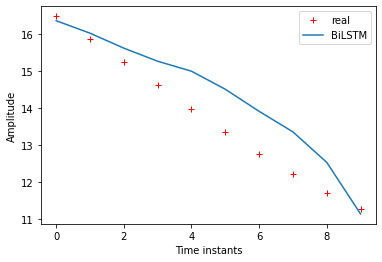

In [ ]:
plt.figure(1)
plt.plot(trueSignalM1_B[10:],'r+', label='real')
plt.plot(signalM1_B[10:], label='BiLSTM')
plt.legend()
plt.xlabel('Time instants')
plt.ylabel('Amplitude')
plt.show()

**Calculate MASE**

In [ ]:
errTotM1 = []

for idx in range(ntestpatterns):
    datainput = X_testM1_B[idx ,:,:]
    datainput = datainput.reshape(1, length, 1)
    realdata = y_testM1_B[idx ,:]
    realdata = np.transpose(realdata).reshape(1,output)
    predicted = modelM1_B.predict(datainput, verbose=0)
    err = MASE(realdata, predicted)
    errTotM1.append(err)

print('Computed PODm1 err Total Error')

Computed PODm1 err Total Error


**Plot MASE for POD mode-1**

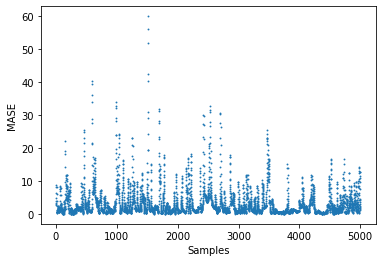

Mean MAE is 3.481923360431399
STD of MAE is 4.548717898594329


In [ ]:
xaxis = np.linspace(1,ntestpatterns, ntestpatterns)

plt.scatter(xaxis, errTotM1, s=0.75)
plt.xlabel('Samples')
plt.ylabel('MASE')
plt.show()
print('Mean MAE is', np.mean(errTotM1))
print('STD of MAE is', np.std(errTotM1))


**Plot loss vs epochs.**

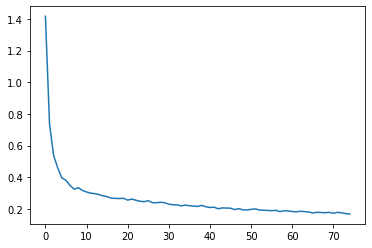

final loss PODm1 0.16806605661091698


In [ ]:
ll = np.load('isoturb32boxROM_PODm1_c2.1_res.npz')
plt.plot(ll['loss_history'])
plt.show()
print('final loss PODm1', ll['loss_history'][-1])